In [10]:
import pandas as pd

#df = pd.read_csv('runs_nb301.csv')

df = pd.read_csv('runs_nb101_cluster.csv')
df2 = pd.read_csv('runs_nb101_ui.csv')
df2['benchmark'] = 'nasbench101'
df = pd.concat([df, df2]).reset_index()

In [11]:
df

,index,benchmark,predictor,seed,dataset,train_size,kendalltau,spearman,train_time,fit_time
0,0,nasbench101,graph_features_xgb,0,cifar10,5,-0.128631,-0.202166,1.063473e+04,0.049912
1,1,nasbench101,graph_features_xgb,0,cifar10,8,0.344654,0.498273,1.472616e+04,0.045091
2,2,nasbench101,graph_features_xgb,0,cifar10,14,0.456949,0.637935,2.645908e+04,0.045792
3,3,nasbench101,graph_features_xgb,0,cifar10,24,0.556858,0.753337,4.427687e+04,0.050003
4,4,nasbench101,graph_features_xgb,0,cifar10,42,0.559437,0.755391,8.127602e+04,0.053891
...,...,...,...,...,...,...,...,...,...,...
23095,4395,nasbench101,seminas,99,cifar10,121,0.557844,0.745008,2.235899e+05,16.428226
23096,4396,nasbench101,seminas,99,cifar10,205,0.584396,0.777088,3.690017e+05,28.261957
23097,4397,nasbench101,seminas,99,cifar10,347,0.635689,0.824369,6.434937e+05,46.962182
23098,4398,nasbench101,seminas,99,cifar10,589,0.657112,0.848361,1.091406e+06,77.181522


In [12]:
run_count = 100

# check if nothing missing
(df.groupby(['benchmark', 'predictor', 'train_size']).count()['seed'] == run_count).all()
assert len(df['benchmark'].unique()) == 1 and len(df['dataset'].unique()) == 1

In [13]:
import numpy as np

def compute_time(include_fit=False):
    plot_time = df['train_time'] + df['fit_time'] if include_fit else df['train_time']
    div = 10 ** np.log10(plot_time).astype(int)
    return plot_time // div * div

df['train time'] = compute_time()
df['runtime'] = compute_time(include_fit=True)

In [14]:
df[['train time', 'train_time']]

,train time,train_time
0,10000.0,1.063473e+04
1,10000.0,1.472616e+04
2,20000.0,2.645908e+04
3,40000.0,4.427687e+04
4,80000.0,8.127602e+04
...,...,...
23095,200000.0,2.235899e+05
23096,300000.0,3.690017e+05
23097,600000.0,6.434937e+05
23098,1000000.0,1.091406e+06


In [15]:
from typing import Optional, Dict, Any, Tuple, Union, Callable, List

import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes
from matplotlib.ticker import FixedLocator
from scipy.stats import t

POINT_TO_INCH = 0.0138889

def remove_x_ticks_beyond(ax: Axes, x_low: float, x_up: float):
    """
    Remove ticks at `z` smaller than `x_low` and greater than `x_up`
    """
    major_ticks = ax.get_xticks()
    minor_ticks = np.vstack(
        [np.linspace(major_ticks[i], major_ticks[i + 1], 6)[1:-1] for i in range(len(major_ticks) - 1)]).flatten()
    minor_ticks = [minor_tick for minor_tick in minor_ticks if x_low <= minor_tick <= x_up]
    ax.set_xticks([x for x in ax.get_xticks() if x_low <= x <= x_up])
    ax.xaxis.set_minor_locator(FixedLocator(minor_ticks))

def plot_rect(x_start: float, x_split: float, x_end: float, y_start: float,
              y_end: float, fill_start: float = 0, x_fill_max: Optional[float] = None,
              alpha: float = .3, color: Optional = None,
              linestyle=":", linewidth=1, ax: Optional[Axes] = None, marker=None, **markerkwargs):
    """
    Plot a squared line from (x_start, y_start) to (x_end, y_end), splitting the lines at `x_split`
    """
    if x_fill_max is None:
        x_fill_max = x_split
    if ax is None:
        ax = plt.subplot()

    if y_end == y_start:
        x_split = x_end
    p = ax.plot([x_start, x_split], [y_start, y_start], linestyle=linestyle, color=color, linewidth=linewidth)
    color = p[0].get_color()
    # if fill_start > 0:
    #     ax.fill_between([x_start, min(x_fill_max, x_split)], [y_start - fill_start, y_start],
    #                     [y_start + fill_start, y_start],
    #                     alpha=alpha, color=color)
    ax.plot([x_split, x_split], [y_start, y_end], linestyle=linestyle, color=color, linewidth=linewidth)
    ax.plot([x_split, x_end], [y_end, y_end], linestyle=linestyle, color=color, linewidth=linewidth, markevery=[1],
            marker=marker, **markerkwargs)

def get_non_stat_diff_bars(data_y: Dict[str, np.ndarray], min_is_the_best: bool,
                           stat_significance_map: Callable[[str, str], bool]) -> Dict[int, List[Tuple[str, str]]]:
    """
    Returns:
        x_ind_to_bar: entry `i` lists the non-statistical difference intervals (key_start, key_end) that should be
                      plotted at level `i` (levels are defined just to avoid overlap)
    """

    ranked_y_keys = sorted(data_y.keys(), key=lambda k: data_y[k][:, -1].mean(), reverse=not min_is_the_best)

    bars: List[Tuple[int, int]] = []
    for i in range(len(ranked_y_keys) - 1):
        start_compare = i + 1
        if len(bars) > 0:
            start_compare = max(start_compare, bars[-1][-1] + 1)
        j = start_compare
        while j < len(ranked_y_keys) and not stat_significance_map(ranked_y_keys[i], ranked_y_keys[j]):
            j += 1
        if j > start_compare:
            bars.append((i, j - 1))

    x_ind_to_bar = {}
    for bar in bars:
        done = False
        for j in range(len(x_ind_to_bar)):
            if bar[0] > x_ind_to_bar[j][-1][-1]:  # no overlap
                x_ind_to_bar.get(j).append(bar)
                done = True
                break
        if not done:
            x_ind_to_bar[len(x_ind_to_bar)] = [bar]

    # convert ind bars to key bars
    for i in x_ind_to_bar:
        x_ind_to_bar[i] = list(map(lambda bar_: (ranked_y_keys[bar_[0]], ranked_y_keys[bar_[1]]), x_ind_to_bar[i]))

    return x_ind_to_bar

def get_split_end(sorted_ys: np.ndarray, y_min: float, y_max: float,
                  x_end_curve: float, x_start_legend: float, default_x_split: float,
                  min_dist_btw_labels: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given a sorted list of y values, give the y_ends values that can be used such
    that i'th label corresponding to (x_end_curve, sorted_ys[i]) would be printed
     at the end of a line ending at (x_start_legend, y_ends[i])

    Args:
        sorted_ys: sorted list of y values
        y_min: y min limit of the ax
        y_max: y max limit of the ax
        x_end_curve: curves stop at x_end_curve
        x_start_legend: legend should be printed just after x_start legend
        default_x_split: if line is not squared, value of the x_split
        min_dist_btw_labels: minimum vertical distance between two labels
    """
    y_ends = []
    x_splits = []
    upper_y_limit = max((min(sorted_ys) + max(sorted_ys) + min_dist_btw_labels * (len(sorted_ys) - 1)) / 2,
                        max(sorted_ys))

    next_y = y_min
    for i in range(len(sorted_ys)):
        if sorted_ys[i] < next_y:  # cannot be straight
            y_ends.append(next_y)
        else:  # straight
            y_ends.append(sorted_ys[i])

        next_y = y_ends[-1] + min_dist_btw_labels

    if y_ends[-1] > upper_y_limit:  # readjust from largest to smallest
        next_y = upper_y_limit
        for i in range(-1, -len(sorted_ys) - 1, -1):
            if y_ends[i] > next_y:  # is not straight
                y_ends[i] = min(next_y, y_ends[i])

            next_y = y_ends[i] - min_dist_btw_labels

    y_ends = np.array(y_ends)

    if max(y_ends) > y_max or min(y_ends) < y_min:
        y_ends = y_min + (y_ends - min(y_ends)) * (y_max - y_min) / (max(y_ends) - min(y_ends))

    default_x = default_x_split
    n_to_split_x_up = 0
    n_to_split_x_down = 0
    for i in range(len(y_ends)):
        if y_ends[i] == sorted_ys[i]:
            if n_to_split_x_up > 0:
                x_splits.extend(
                    list((x_start_legend - x_end_curve) * np.linspace(0, 1, n_to_split_x_up + 2)[1:-1] + x_end_curve)[
                    ::-1])
                n_to_split_x_up = 0
            if n_to_split_x_down > 0:
                x_splits.extend(
                    list((x_start_legend - x_end_curve) * np.linspace(0, 1, n_to_split_x_down + 2)[1:-1] + x_end_curve))
                n_to_split_x_down = 0
            x_splits.append(default_x)
        elif y_ends[i] < sorted_ys[i]:
            if n_to_split_x_up > 0:
                x_splits.extend(
                    list((x_start_legend - x_end_curve) * np.linspace(0, 1, n_to_split_x_up + 2)[1:-1] + x_end_curve)[
                    ::-1])
                n_to_split_x_up = 0
            n_to_split_x_down += 1
        elif y_ends[i] > sorted_ys[i]:
            if n_to_split_x_down > 0:
                x_splits.extend(
                    list((x_start_legend - x_end_curve) * np.linspace(0, 1, n_to_split_x_down + 2)[1:-1] + x_end_curve))
                n_to_split_x_down = 0
            n_to_split_x_up += 1

    if n_to_split_x_down > 0:
        x_splits.extend(
            list((x_start_legend - x_end_curve) * np.linspace(0, 1, n_to_split_x_down + 2)[1:-1] + x_end_curve)
        )
    if n_to_split_x_up > 0:
        x_splits.extend(
            list((x_start_legend - x_end_curve) * np.linspace(0, 1, n_to_split_x_up + 2)[1:-1] + x_end_curve)[::-1]
        )

    x_splits = np.array(x_splits)
    return y_ends, x_splits

def plot_mean_std(*args, n_std: Optional[float] = 1,
                  ax: Optional[Axes] = None, alpha: float = .3, errbar: bool = False,
                  lb: Optional[Union[float, np.ndarray]] = None,
                  ub: Optional[Union[float, np.ndarray]] = None,
                  linewidth: int = 3,
                  show_std_error: Optional[bool] = False,
                  ci_level: Optional[float] = None,
                  **plot_mean_kwargs):
    """ Plot mean and std (with fill between) of sequential data Y of shape (n_trials, lenght_of_a_trial)

    Args:
        X: x-values (if None, we will take `range(0, len(Y))`)
        Y: y-values
        n_std: number of std to plot around the mean (if `0` only the mean is plotted)
        ax: axis on which to plot the curves
        color: color of the curve
        alpha: parameter for `fill_between`
        errbar: use error bars instead of shaded area
        ci_level: show confidence interval over the mean at specified level (e.g. 0.95), otherwise uncertainty shows
          n_std std around the mean
        lb: lower bound (to clamp uncertainty region)
        ub: upper bound (to clamp uncertainty region)
        show_std_error: show standard error (std / sqrt(n_samples)) as shadow area around mean curve

    Returns:
        The axis.
    """
    if len(args) == 1:
        Y = args[0]
        X = None
    elif len(args) == 2:
        X, Y = args
    else:
        raise RuntimeError('Wrong number of arguments (should be [X], Y,...)')

    assert len(Y) > 0, 'Y should be a non-empty array, nothing to plot'
    Y = np.atleast_2d(Y)
    if X is None:
        X = np.arange(Y.shape[1])
    assert X.ndim == 1, f'X should be of rank 1, got {X.ndim}'
    mean = Y.mean(0)
    std = Y.std(0)
    if ax is None:
        ax = plt.subplot()

    if len(X) == 0:
        return ax

    if ci_level is not None and len(Y) > 1:
        # student
        t_crit = np.abs(t.ppf((1 - ci_level) / 2, len(Y) - 1))
        n_std = t_crit / np.sqrt(len(Y))
    elif show_std_error:
        n_std = 1 / np.sqrt(len(Y))

    if errbar:
        n_errbars = min(10, len(std))
        errbar_inds = len(std) // n_errbars
        ax.errorbar(X, mean, yerr=n_std * std, errorevery=errbar_inds, linewidth=linewidth, **plot_mean_kwargs)
    else:
        line_plot = ax.plot(X, mean, linewidth=linewidth, **plot_mean_kwargs)

        if n_std > 0 and Y.shape[0] > 1:
            uncertainty_lb = mean - n_std * std
            uncertainty_ub = mean + n_std * std
            if lb is not None:
                uncertainty_lb = np.maximum(uncertainty_lb, lb)
            if ub is not None:
                uncertainty_ub = np.minimum(uncertainty_ub, ub)

            ax.fill_between(X, uncertainty_lb, uncertainty_ub, alpha=alpha, color=line_plot[0].get_c())

    return ax

def get_ax_size(ax: Axes) -> Tuple[float, float]:
    fig = plt.gcf()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    return bbox.width, bbox.height

def plot_curves_with_ranked_legends(
        ax: Axes,
        data_y: Dict[str, np.ndarray],
        data_x: Union[np.ndarray, Dict[str, np.ndarray]],
        data_lb: Optional[Union[Dict[str, np.ndarray], np.ndarray, float]] = None,
        data_ub: Optional[Union[Dict[str, np.ndarray], np.ndarray, float]] = None,
        data_key_to_label: Optional[Union[Dict[str, str], Callable[[str], str]]] = None,
        data_marker: Optional[Dict[str, str]] = None,
        data_color: Optional[Dict[str, str]] = None,
        alpha: float = .3,
        n_std: float = 1,
        label_fontsize: int = 18,
        linewidth: int = 3,
        marker_kwargs: Optional[Dict[str, Any]] = None,
        ci_level: Optional[float] = None,
        show_std_error: Optional[bool] = False,
        min_is_the_best: bool = False,
        stat_significance_map: Optional[Union[Dict[Tuple[str, str], bool], Callable[[Tuple[str, str]], bool]]] = None,
        zoom_end_pct: Optional[float] = None
):
    """
    Plot curves with legends written vertically with position corresponding to the final values (final regrets, scores,
    ...) on the right of the plot.

    Args:
        data_lb: lower bound for confidence interval (for instance if values are known to be in [0, 1])
        data_ub: upper bound for confidence interval (for instance if values are known to be in [0, 1])
        data_key_to_label: map from keys of data_y to the labels that should appear as legend
        ci_level: show confidence interval over the mean at specified level (e.g. 0.95), otherwise uncertainty shows
                  n_std std around the mean
        show_std_error: show standard error (std / sqrt(n_samples)) as shadow area around mean curve
        min_is_the_best: whether minimal values are better
        stat_significance_map: a map such that map(k1, k2) is True if the means of k1 and k2 are statistically different
        zoom_end_pct: reset ylimits such that end performances occupies at least `zoom_end_pct` of the screen.

    Returns:
        ax: axis containing the plots
        y_ends: array of vertical positions of the legend
        x_start_legend: x value at which legend lines start
        x_start_legend_text: x value at which labels are written

    """

    if marker_kwargs is None:
        marker_kwargs = DEFAULT_MARKER_KWARGS

    if data_marker is None:
        data_marker = {data_key: MARKERS[i % len(MARKERS)] for i, data_key in enumerate(data_y)}

    if data_key_to_label is None:
        data_key_to_label = {data_k: data_k for data_k in data_y}
    if isinstance(data_key_to_label, dict):
        data_key_to_label_map = lambda k: data_key_to_label.get(k, k)
    else:
        data_key_to_label_map = data_key_to_label

    if isinstance(stat_significance_map, dict):
        stat_significance_map = lambda k1, k2: stat_significance_map.get((k1, k2), False)

    if not isinstance(data_x, dict):
        data_x = {data_key: data_x for data_key in data_y}

    if not isinstance(data_lb, dict):
        data_lb = {data_key: data_lb for data_key in data_y}

    if not isinstance(data_ub, dict):
        data_ub = {data_key: data_ub for data_key in data_y}

    _, ax_height = get_ax_size(ax)

    max_x = -np.inf
    min_x = np.inf

    max_y_end = -np.inf
    min_y_end = np.inf

    value_for_rank_1 = {}
    value_for_rank_2 = {}

    for data_key in data_y:
        y = data_y[data_key]

        if y.ndim == 1:
            y = y.reshape(1, -1)
        value_for_rank_1[data_key] = y[:, -1].mean()
        value_for_rank_2[data_key] = y.mean()

    sorted_data_keys = sorted(data_y.keys(), key=lambda label: (value_for_rank_1[label], value_for_rank_2[label]))
    rank_of_key = {k: i for i, k in enumerate(sorted_data_keys)}

    if data_color is None:
        # data_color = {data_key: COLORS[rank % len(COLORS)] for rank, data_key in enumerate(sorted_data_keys[::-1])}
        data_color = {data_key: COLORS[i % len(COLORS)] for i, data_key in enumerate(data_y)}

    for rank, data_key in enumerate(sorted_data_keys):
        x = data_x[data_key]
        y = data_y[data_key]

        if y.ndim == 1:
            y = y.reshape(1, -1)

        max_x = max(max_x, x[-1])
        min_x = min(min_x, x[0])

        markers_on = 1

        marker = data_marker.get(data_key) if (len(sorted_data_keys) - rank) < 4 else ''
        color = data_color.get(data_key)
        if ci_level is not None and len(y) > 1:
            # student
            t_crit = np.abs(t.ppf((1 - ci_level) / 2, len(y) - 1))
            n_std = t_crit / np.sqrt(len(y))
        elif show_std_error:
            n_std = 1 / np.sqrt(len(y))
        plot_mean_std(
            x, y, lb=data_lb[data_key], ub=data_ub[data_key],
            linewidth=linewidth, ax=ax, color=color, alpha=alpha, n_std=n_std,
            marker=marker, markevery=markers_on, **marker_kwargs, zorder=(rank + 1) * 100
        )

        max_y_end = max(y[:, -1].mean() + n_std * y[:, -1].std(), max_y_end)
        min_y_end = min(y[:, -1].mean() - n_std * y[:, -1].std(), min_y_end)

    # -------- Plot dotted lines to legend ----------
    ymin, ymax = ax.get_ylim()
    if zoom_end_pct:
        current_pct = (max_y_end - min_y_end) / (ymax - ymin)
        if current_pct < zoom_end_pct:
            gamma = 1 / ((ymax - ymin) - (max_y_end - min_y_end)) * (
                    ymax - ymin - (max_y_end - min_y_end) / zoom_end_pct)
            ymin = ymin + gamma * (min_y_end - ymin)
            ymax = ymax - gamma * (ymax - max_y_end)
            ax.set_ylim(ymin, ymax)

    x_start_legend = min_x + (max_x - min_x) * 1.1
    if len(sorted_data_keys) > 2:
        x_start_legend = max(x_start_legend, max_x + 25)
    min_dist_btw_labels = (ymax - ymin) / ax_height * max(label_fontsize,
                                                          marker_kwargs["markeredgewidth"] + marker_kwargs[
                                                              "markersize"] + 5) * POINT_TO_INCH * 1.5

    default_x_split = (max_x + x_start_legend) / 2
    y_ends, x_splits = get_split_end(
        sorted_ys=np.array([value_for_rank_1[label] for label in sorted_data_keys]),
        y_min=ymin,
        y_max=ymax,
        x_end_curve=max_x,
        x_start_legend=x_start_legend,
        default_x_split=default_x_split,
        min_dist_btw_labels=min_dist_btw_labels
    )

    x_start_label = x_start_legend + (max_x - min_x) * .04

    # -------- Plot vertical bars for non-significant results --------
    if stat_significance_map:

        x_ind_to_bar = get_non_stat_diff_bars(data_y=data_y, min_is_the_best=min_is_the_best,
                                              stat_significance_map=stat_significance_map)

        label_offset = 0.05 * (max_x - min_x) * max(1, len(x_ind_to_bar))
        if len(sorted_data_keys) > 2:
            label_offset = max(label_offset, 25)
        x_start_label += label_offset

        x_col = np.linspace(x_start_legend, x_start_label, len(set(x_ind_to_bar)) + 5)[2:-1]

        for y_end in y_ends:
            plt.plot([x_col[0], x_col[-1]], [y_end, y_end], marker=".", c='k')

        x_col = x_col[1:-1]

        for x_ind, key_bars in x_ind_to_bar.items():
            for key_bar in key_bars:
                y0 = y_ends[rank_of_key[key_bar[0]]]
                y1 = y_ends[rank_of_key[key_bar[1]]]
                ax.plot([x_col[x_ind], x_col[x_ind]], [y0, y1], c="k", linewidth=3)

    for i, data_key in enumerate(sorted_data_keys):
        y = data_y[data_key]

        if y.ndim == 1:
            y = y.reshape(1, -1)
        fill_start = 0 if len(y) == 1 else y[:, -1].std() * n_std

        plot_rect(
            x_start=max_x,
            x_split=x_splits[i],
            x_end=x_start_legend,
            y_start=y[:, -1].mean(),
            y_end=y_ends[i],
            fill_start=fill_start,
            x_fill_max=default_x_split,
            alpha=alpha,
            color=data_color[data_key],
            ax=ax,
            marker=data_marker[data_key],
            linewidth=linewidth,
            **marker_kwargs
        )

        text = data_key_to_label_map(data_key)
        plt.text(x_start_label, y_ends[i], text,
                 fontsize=label_fontsize, va="center", ha="left")

    ax.set_ylim(min(ymin, min(y_ends) - min_dist_btw_labels / 2), max(ymax, max(y_ends) + min_dist_btw_labels / 2))

    # -------- Remove the ticks beyond last x --------
    xlim_min, xlim_max = ax.get_xlim()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()

    remove_x_ticks_beyond(ax=ax, x_low=-np.inf, x_up=max_x)

    ax.set_xlim(xlim_min, xlim_max)

    ax.spines["bottom"].set_bounds(xlim_min, max_x)

    # -------- Plot vertical line separating plot and legend -------
    ymin, ymax = ax.get_ylim()

    ax.plot([max_x, max_x], [ymin, ymax], linestyle="--", color="k", linewidth=linewidth, zorder=0)

    ax.set_ylim(ymin, ymax)

    # -----------------------------------------------

    return ax, y_ends, x_start_legend, x_start_label

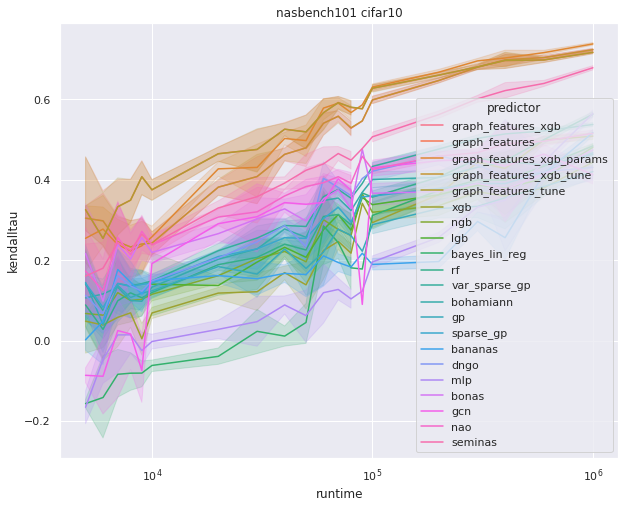

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(10,8))
sns.lineplot(data=df, x='runtime', y='kendalltau', hue='predictor')
plt.title(f"{df.iloc[0]['benchmark']} {df.iloc[0]['dataset']}")
plt.xscale('log')

plt.show()

In [17]:
plot_val = "kendalltau"

all_res = df.copy()
all_res.fillna(0, inplace=True)

sub_regret_df = all_res.copy()
aux_group = sub_regret_df.groupby(["benchmark", "train_size", "seed"])
sub_regret_df["rank"] = aux_group[["kendalltau"]].rank()

num_evals = sub_regret_df.train_size.unique()
num_evals.sort()
group_col = "predictor"

opt_to_rank_dict = {}
all_opt_to_rank_dicts = {}

for num_eval in num_evals:
    for opt_name, rank_data  in sub_regret_df[sub_regret_df["train_size"] == num_eval].groupby(group_col)[plot_val]:
        if opt_name not in opt_to_rank_dict:
            opt_to_rank_dict[opt_name] = []
        opt_to_rank_dict[opt_name].append(rank_data.values)

for opt_name in opt_to_rank_dict:
    opt_to_rank_dict[opt_name] = np.array(opt_to_rank_dict[opt_name]).T

all_opt_to_rank_dicts["None"] = opt_to_rank_dict.copy()

In [18]:
import scikit_posthocs as sp
import scipy.stats as stats

eval_budget = num_evals[-1]
pval_threshold = 0.05

sub_regret_eval_df = sub_regret_df[sub_regret_df["train_size"] == eval_budget]

# Each row corresponds to a task and seed
ranks_per_task_seed = np.array([v.values for _, v in sub_regret_eval_df.groupby(["benchmark", "seed"])[plot_val]])

friedman_test_pvalue = stats.friedmanchisquare(*ranks_per_task_seed.T).pvalue

if friedman_test_pvalue >= 0.05:
    print(f"All ranks may be equally distributed: Friedman test p-value={friedman_test_pvalue}")
    
test_results = sp.posthoc_wilcoxon(sub_regret_eval_df, val_col=plot_val, group_col=group_col, zero_method="pratt") 

test_results_map = lambda k1, k2: test_results.loc[k1][k2].item() < pval_threshold

/tmp/ipykernel_1253/3452102126.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


{'graph_features_xgb': 'graph_features_xgb', 'graph_features': 'graph_features', 'graph_features_xgb_params': 'graph_features_xgb_params', 'graph_features_xgb_tune': 'graph_features_xgb_tune', 'graph_features_tune': 'graph_features_tune', 'xgb': 'xgb', 'ngb': 'ngb', 'lgb': 'lgb', 'bayes_lin_reg': 'bayes_lin_reg', 'rf': 'rf', 'var_sparse_gp': 'var_sparse_gp', 'bohamiann': 'bohamiann', 'gp': 'gp', 'sparse_gp': 'sparse_gp', 'bananas': 'bananas', 'dngo': 'dngo', 'mlp': 'mlp', 'bonas': 'bonas', 'gcn': 'gcn', 'nao': 'nao', 'seminas': 'seminas'}


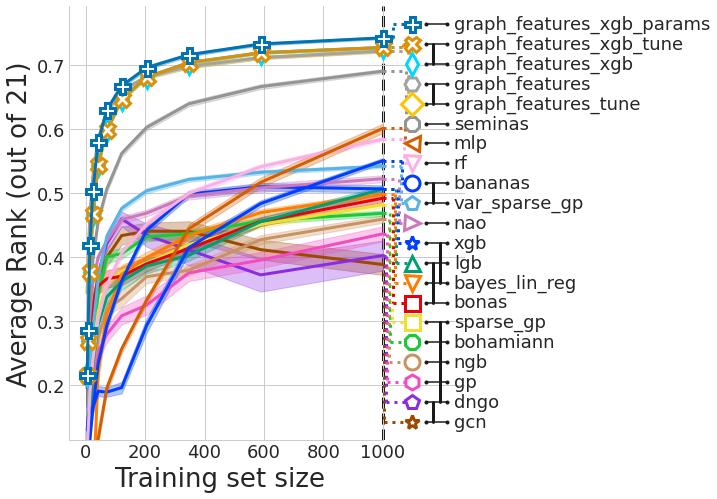

In [20]:
plt.style.use('seaborn-whitegrid')
COLORS = sns.color_palette("bright") + sns.color_palette("colorblind")
MARKERS = ['o', 'v', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '^', '<', '>']

DEFAULT_MARKER_KWARGS = dict(
    markersize=15,
    fillstyle="full",
    markeredgewidth=3,
    markerfacecolor="white",
)

data_marker = {data_key: MARKERS[i % len(MARKERS)] for i, data_key in enumerate(opt_to_rank_dict)}
data_color = {data_key: COLORS[i % len(COLORS)] for i, data_key in enumerate(opt_to_rank_dict)}

fig, ax = plt.subplots(figsize=(10, 7))

data_key_to_label = {p:p for p in df.predictor.unique()}

print(data_key_to_label)

plot_curves_with_ranked_legends(
    ax=ax,
    data_y=opt_to_rank_dict,
    data_x=num_evals,
    show_std_error=True,
    min_is_the_best=True,
    data_key_to_label=data_key_to_label, 
    stat_significance_map=test_results_map,
    data_color=data_color,
    data_marker=data_marker,
    zoom_end_pct=0.6
)

ax.set_ylabel(f"Average Rank (out of {len(data_key_to_label)})", fontsize=26)
ax.set_xlabel("Training set size", fontsize=26)
ax.xaxis.set_label_coords(.38, -0.06)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.tight_layout()
plt.savefig(f"./avg_rank_comb.png")

plt.show()